In [1]:
import torch
import pickle
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.functional import cosine_similarity

In [2]:
class CLIPModel(nn.Module):
    def __init__(self, image_encoder_dim, text_encoder_dim, output_dim):
        super().__init__()

        self.image_proj = nn.Linear(image_encoder_dim, output_dim)
        self.text_proj = nn.Linear(text_encoder_dim, output_dim)
        self.embed_dim = output_dim

        print(image_encoder_dim, text_encoder_dim, output_dim)

    def forward(self, image_tensor, text_tensor):
        # Projection
        image_embeddings = self.image_proj(image_tensor)
        text_embeddings = self.text_proj(text_tensor)
    
        # Normalization
        image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
        text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)
        
        return image_embeddings, text_embeddings

In [3]:
class PrecomputedDataset(Dataset):
    def __init__(self, emb_images_file, emb_captions_file, device="cuda"):
        with open(emb_images_file, "rb") as f:
            self.eimg = pickle.load(f)

        with open(emb_captions_file, "rb") as f:
            self.etext = pickle.load(f)

        self.device = device
        self.keys = list(self.etext.keys())
    
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, idx):
        key_text = self.keys[idx]
        # Feltételezzük, hogy self.etext[key_text]["emb"] tensor formátumú
        tensor_text = self.etext[key_text]["emb"].clone().detach().to(self.device)
        
        key_img = self.etext[key_text]["img_fn"]
        # Feltételezzük, hogy self.eimg[key_img] tensor formátumú
        tensor_img = self.eimg[key_img].clone().detach().to(self.device)       

        meta = {
            "img_name" : key_img,
            "caption" : self.etext[key_text]["caption"]
        }
        return tensor_img, tensor_text, meta

In [4]:
class CLIPLossWithCompensation(nn.Module):
    def __init__(self, initial_temperature=0.07, initial_alpha=0.1):
        super(CLIPLossWithCompensation, self).__init__()
        self.loss_fn = nn.CrossEntropyLoss()
        # Define the temperature parameter as a learnable parameter
        self.temperature = nn.Parameter(torch.tensor(initial_temperature))
        # Scaling factor for the compensation
        self.alpha = nn.Parameter(torch.tensor(initial_alpha)) # alpha

    def forward(self, image_features, text_features):
        # Normalize the features to compute cosine similarity
        image_features = F.normalize(image_features, p=2, dim=-1)
        text_features = F.normalize(text_features, p=2, dim=-1)

        # Compute logits scaled with learnable temperature
        logits = torch.matmul(image_features, text_features.t()) / self.temperature

        # Compute pairwise cosine similarity for images and texts
        image_sim = torch.matmul(image_features, image_features.t())  # Image-to-image similarity
        text_sim = torch.matmul(text_features, text_features.t())    # Text-to-text similarity

        # Compute dynamic weights for the logits based on similarity
        weights = 1 + self.alpha * (image_sim + text_sim) / 2  # Average of image and text similarity

        # Apply weights to the logits
        weighted_logits = logits * weights

        # Create labels for the positive pairs
        labels = torch.arange(logits.shape[0], device=logits.device)

        # Compute the loss for both directions
        loss = (self.loss_fn(weighted_logits, labels) + self.loss_fn(weighted_logits.t(), labels)) / 2
        return loss

In [5]:
dataset_val = PrecomputedDataset(emb_images_file="data/coco/embs/val2017_images.pkl",
                             emb_captions_file="data/coco/embs/val2017_captions.pkl")
len(list(dataset_val.eimg.keys())), len(list(dataset_val.etext.keys()))

(5000, 5000)

In [6]:
model = CLIPModel(image_encoder_dim=2048, text_encoder_dim=768, output_dim=512)
model = model.to("cuda")

2048 768 512


In [9]:
loss_fn=CLIPLossWithCompensation()
optimizer = optim.Adam(list(model.parameters()) + list(loss_fn.parameters()), lr=1e-4, weight_decay=1e-6)

/opt/conda/envs/clip/lib/python3.10/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [10]:
checkpoint = torch.load("models/last-compensated/model.pth", weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
sims = []
itemidx = 0
tensor_img_0, tensor_text_0, _ = dataset_val[itemidx]
for tensor_img, tensor_text, _ in tqdm(dataset_val):
    image_embedding, text_embedding = model(tensor_img_0, tensor_text)
    similarity = cosine_similarity(image_embedding.unsqueeze(0), text_embedding.unsqueeze(0))
    sims.append((similarity.item() + 1) / 2)

 49% 2457/5000 [00:00<00:00, 2701.96it/s]

In [16]:
dataset_val[itemidx]

(tensor([0.5390, 0.0243, 0.3132,  ..., 0.1676, 0.5686, 0.3568], device='cuda:0'),
 tensor([-7.7156e-01, -8.6230e-02, -9.2755e-01,  1.0128e-01,  1.5191e-01,
          1.1935e-01, -3.0292e-01,  5.4733e-01, -4.4829e-01, -2.2846e-01,
         -4.6525e-02, -7.0054e-01, -3.5767e-01,  6.5887e-01,  1.5110e-01,
          3.0363e-02, -1.8102e-03,  6.8606e-01,  1.9879e-01,  4.4276e-02,
          2.9459e-01, -4.7510e-01, -7.7016e-01,  4.3389e-02, -1.8684e-01,
         -2.8023e-01,  4.8517e-01,  1.0428e-01,  6.5320e-02,  1.0706e-01,
          2.2990e-01,  5.9882e-02, -3.5811e-01, -6.3794e-01,  5.9485e-01,
         -7.1848e-01,  7.4450e-01, -1.8400e-01, -5.2412e-01, -1.3920e-01,
         -3.4669e-01, -2.8396e-03,  7.4436e-01, -1.8410e-02,  2.7025e-01,
         -3.8239e-01, -2.5843e+00,  4.6731e-02, -5.5937e-01,  1.2707e-01,
          3.1401e-01, -3.6453e-01,  2.8647e-01,  4.9289e-01,  1.8417e-01,
          1.0416e+00, -1.2996e-01,  4.8595e-01,  6.1129e-01, -1.2377e-03,
          1.2504e-01, -9.5402e

<Axes: >

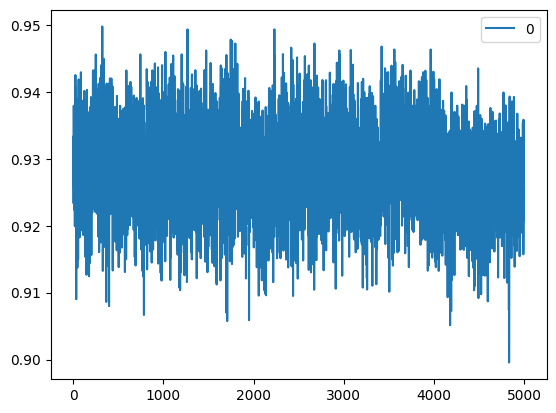

In [13]:
sims = pd.DataFrame(sims)
sims.plot()

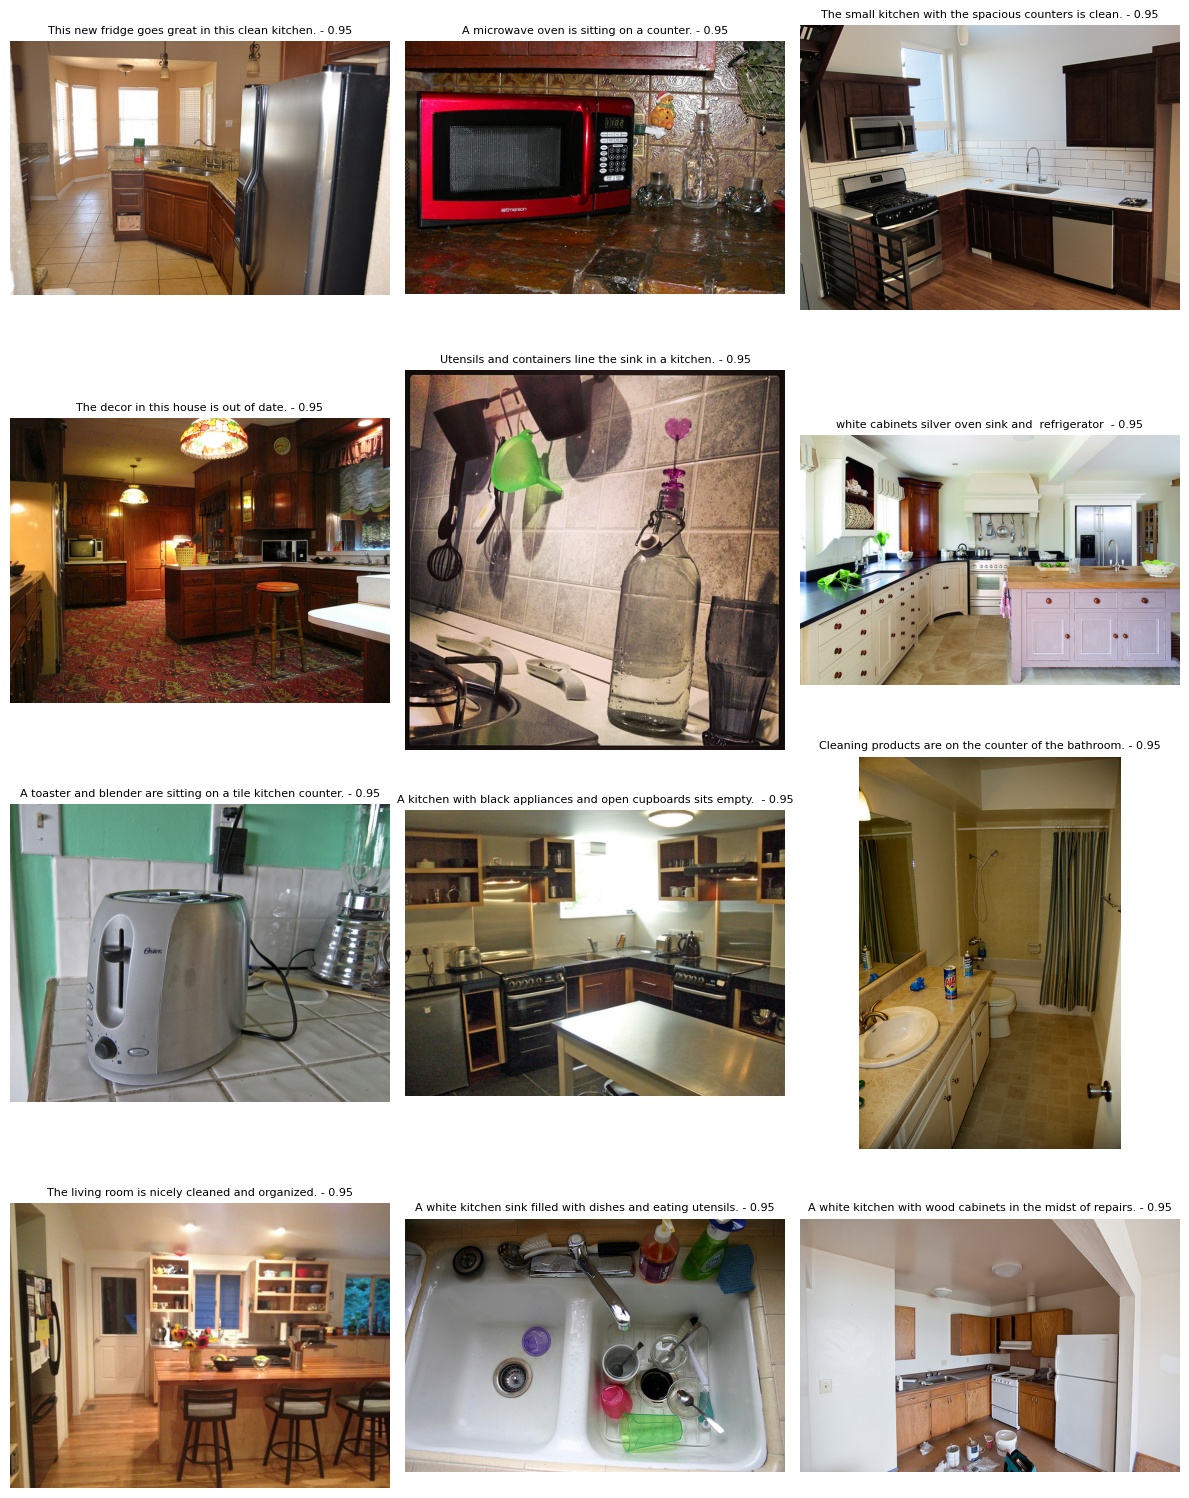

In [15]:
images = []
metas = []
max_columns = 3
image_count = 12

nlargest = sims[0].nlargest(image_count).index
for idx in nlargest:
    _, _, meta = dataset_val[idx]
    images.append(Image.open("data/coco/val2017/val2017/" + meta["img_name"]).convert("RGB"))
    metas.append(meta)

# Grid méretek kiszámítása
rows = (len(images) + max_columns - 1) // max_columns
# Matplotlib grid létrehozása
fig, axes = plt.subplots(rows, max_columns, figsize=(12, 4 * rows))

# Az ábrákra képek helyezése
for i, ax in enumerate(axes.flatten()):
    ax.set_title(metas[i]["caption"] + " - " + str(round(sims[0].values[nlargest[i]],2)), fontsize=8)
    if i < len(images):
        ax.imshow(images[i])
        ax.axis("off")  # Kikapcsolja az axis vonalakat
    else:
        ax.axis("off")  # Üres cellák esetén is kapcsolja ki az axis vonalakat

plt.tight_layout()
plt.show()